# Training of PCA & RF !! NIET OPNIEUW RUNNEN

## Import Modules

In [1]:
# Import data module
from adni.load_data import load_data
# Import needed modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score #kan elke zijn die we willen gebruiken

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

Data loading

In [20]:
# Data loading 
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
df= pd.DataFrame(data)

# Reset index, add patient ID's as column
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'ID'})

# set seed

The number of samples: 855
The number of columns: 268


Data Cleaning

In [21]:
# Check wheter there is missing data (NaN)
df.notnull().values.any() # Geen missing data

# Als SD 0 dan feature weggooien
df.drop(df.std()[df.std() == 0].index.values, axis = 1)

print(f'The number of samples after cleaning + std: {len(df.index)}')
print(f'The number of columns after cleaning + std: {len(df.columns)}')

# Count number of duplicated patiient ID's
df.index.duplicated().sum() # ID's are indices in df
X = df.drop('ID', axis=1) # Drop patient ID)

The number of samples after cleaning + std: 855
The number of columns after cleaning + std: 269


/var/folders/51/0_464swx7kq7rfsptvkcf_gw0000gn/T/ipykernel_24212/3169578223.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.drop(df.std()[df.std() == 0].index.values, axis = 1)


## Data split in test, train and validation set 

Split data in test-set & train/validation-set

In [22]:
# Test / Train split: stratified op label --> nagaan of we dit ook willen
y = df['label'] # Define label y (output)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.25, stratify=X['label'], random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = X_train['label'], random_state=1)

# Drop labels and drop patient ID
X_train = X_train.drop('label', axis=1)
#X_val = X_val.drop('label', axis=1)
X_test = X_test.drop('label', axis=1)
X = X.drop('label', axis=1)



# Pipeline with PCA & RF

1. RobustScaler
2. Feature extraction: PCA
3. Classifier: RF 

In [27]:
# Define steps in pipeline
scaler = RobustScaler()         # want data heeft outliers
# scaler = StandardScaler()
pca = PCA()
rf = RandomForestClassifier()

# Create pipeline with steps: scaler, PCA, classifier
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('rf', rf)])

# Define parameters for gridsearch: depending on which classifier
param_grid = {
    "pca__n_components": [int(x) for x in np.linspace(start = 5, stop = 200, num = 5)],
    "rf__n_estimators": [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
    "rf__max_depth": [int(x) for x in np.linspace(10, 120, num = 12)],
}
# Perform Grid Search on pipe
search = RandomizedSearchCV(pipe, param_grid, n_iter = 20, cv = 5, scoring='accuracy')
#search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_train, y_train)

# Print outcome Grid Search
print("Best parameter (CV score=%0.3f):" % search.best_score_)
best_params = search.best_params_
print(best_params) 
#resultscv = search.cv_results_
#print(resultscv)

pipe_after_grid = Pipeline([('scaler', scaler), ('pca', PCA((best_params['pca__n_components']))), ('rf', RandomForestClassifier(n_estimators = (best_params['rf__n_estimators']), max_depth = (best_params['rf__max_depth'])))])

# Fit pipe_after_grid on data
bst = pipe_after_grid.fit(X_train, y_train)

#TEST PERFORMANCE
# y_pred = bst.predict(X_val)
# y_val = (np.array(y_val))
# print(bst.score(X_val, y_val))

#print(recall_score(y_val, y_pred))
#print(precision_score(y_val, y_pred))


Best parameter (CV score=0.802):
{'rf__n_estimators': 700, 'rf__max_depth': 80, 'pca__n_components': 200}


In [28]:
#apply trained pipe to test-set
y_pred = bst.predict(X_test)
y_test = (np.array(y_test))
print(bst.score(X_test, y_test))

0.7663551401869159


# Feature importance

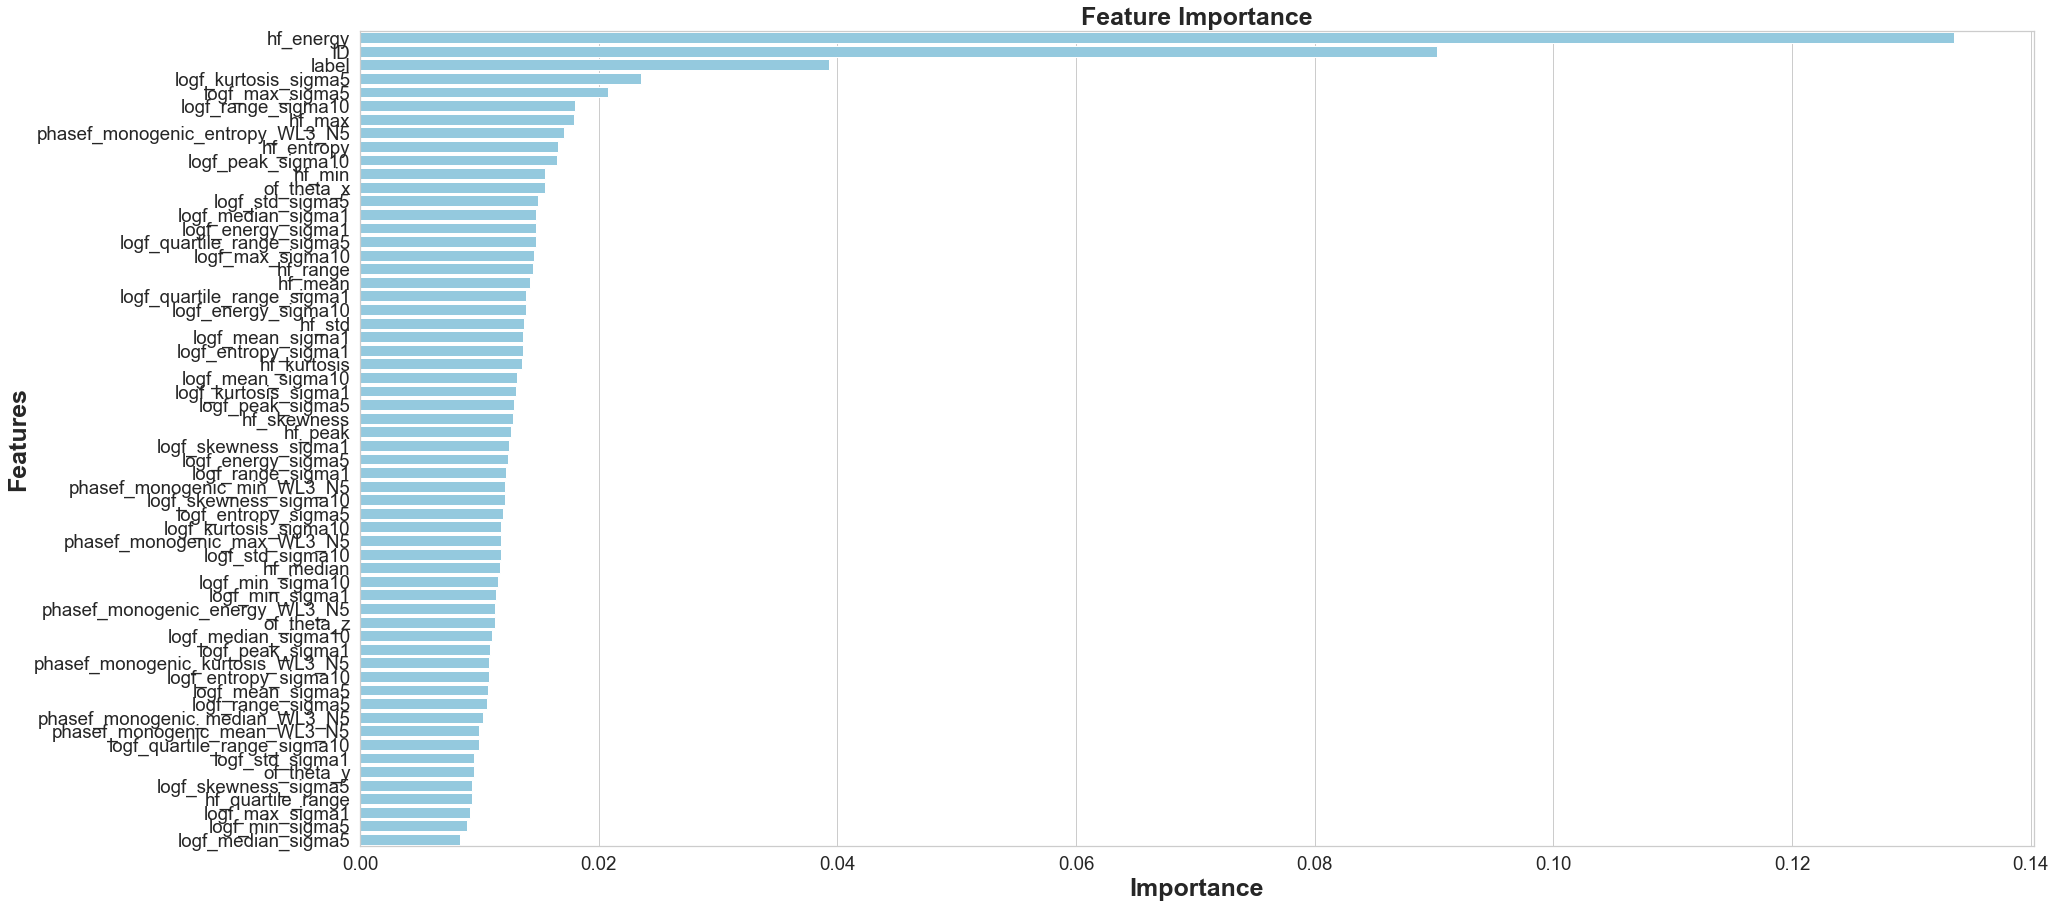

None

,Features,Gini-Importance
0,hf_energy,0.133582
1,ID,0.090284
2,label,0.039321
3,logf_kurtosis_sigma5,0.023557
4,logf_max_sigma5,0.020787
5,logf_range_sigma10,0.018001
6,hf_max,0.017908
7,phasef_monogenic_entropy_WL3_N5,0.017118
8,hf_entropy,0.016625
9,logf_peak_sigma10,0.016519


In [ ]:
feats = {}
for feature, importance in zip(data.columns, rf.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})

sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')

display(plt.show())
display(importances)

# PCA - number of components

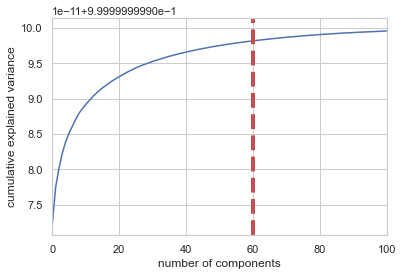

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,1.0,1.000000e+00
1,1.0,5.334648e-12
2,1.0,2.713400e-12
3,1.0,2.125537e-12
4,1.0,1.611188e-12
5,1.0,1.203963e-12
6,1.0,1.009500e-12
7,1.0,9.762353e-13
8,1.0,8.501116e-13
9,1.0,6.453851e-13


In [ ]:
X_train_scaled = scaler.transform(X_train)

pca_test = PCA()
pca_test.fit(X_train_scaled)

sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=60, ymin=0, ymax=1)
plt.xlim(0,100)
display(plt.show())

evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))